# Introduction

This notebook backtests 100 stock tickers. After reading in the stock tickers from a CSV file, it calls `backtester()` to do all the hard work. This is basically a wrapper for the `backtester()`. The `backtester()` is stored in backtest.py.

In [1]:
from backtest import get_hist, smooth, features, stringify, print_ticker_heading, balanced_scorecard, \
                     determine_minima_n_maxima, align_minima_n_maxima, plot_trades, split_data, \
                     get_signals, merge_buy_n_sell_signals, extract_trades, get_possible_trades, \
                     backtester
import pandas as pd
import numpy as np

from   frankie     import DayForecast, optimize, baseline, cross_val_tpr
import yfinance as yf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

from datetime import date, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import savgol_filter, argrelmin, argrelmax

import gc; gc.enable()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# suppress output of plotting all the trades as this is quite a lot...
# plot_trades(tickers, min_indices, max_indices)

In [4]:
DATAPATH = '/Users/frkornet/Flatiron/Stock-Market-Final-Project/data/'
sdf = pd.read_csv(f'{DATAPATH}stocks_100.csv')
idx = (sdf.TICKER > '')
sdf = sdf.loc[idx].reset_index()
tickers = sdf.TICKER.to_list()

In [5]:
%time myPnL_df, my_Capital_df, possible_trades_df, buy_opportunities_df = backtester("backtest_0100.log", tickers, "10y", 10000, 5)

Simulating 93 stocks



local minima and maxima: 100%|██████████| 93/93 [00:48<00:00,  1.90it/s]



Unable to determine local minima and maxima for the following tickers:
['GS']
Simulating with remaining 92 stocks



possible trades: 100%|██████████| 92/92 [02:06<00:00,  1.37s/it]



Possible trades to simulate: 913
Trading days to simulate   : 770



simulate trades: 100%|██████████| 770/770 [01:55<00:00,  6.69it/s]


Today's buying recommendations:

   ticker   buy_date  buy_close  trading_days  gain_pct  daily_return
55   OPCH 2020-02-26      14.98     22.166667  5.706667      0.315833
8    BMCH 2020-02-26      27.92     19.000000  4.808000      0.156000
74   TOWN 2020-02-26      25.62     24.473684  0.271053      0.144737
9     BXP 2020-02-26     135.41     19.500000  1.802222      0.141667


Yesterday's buying recommendations:

   ticker   buy_date  buy_close  trading_days  gain_pct  daily_return
5    AMWD 2020-02-25      98.47     24.928571  2.857857      0.827143
59   PCAR 2020-02-25      69.99     13.722222  1.742778      0.331111
41    IQV 2020-02-25     150.06     30.166667  7.771667      0.321667
81     VZ 2020-02-25      57.12     15.411765  3.554706      0.157059
54   OTEX 2020-02-25      43.71     55.200000  6.080000      0.148000

CPU times: user 6min 17s, sys: 2.83 s, total: 6min 20s
Wall time: 4min 54s


# Summary Chart

This chart provides an overview of well the backtest went and how it increased or decreased the initial capital over time.

In [6]:
idx = myPnL_df.action=='BUY'
first_buy_date = myPnL_df.loc[idx].date.min()
first_buy_date

Timestamp('2017-02-08 00:00:00')

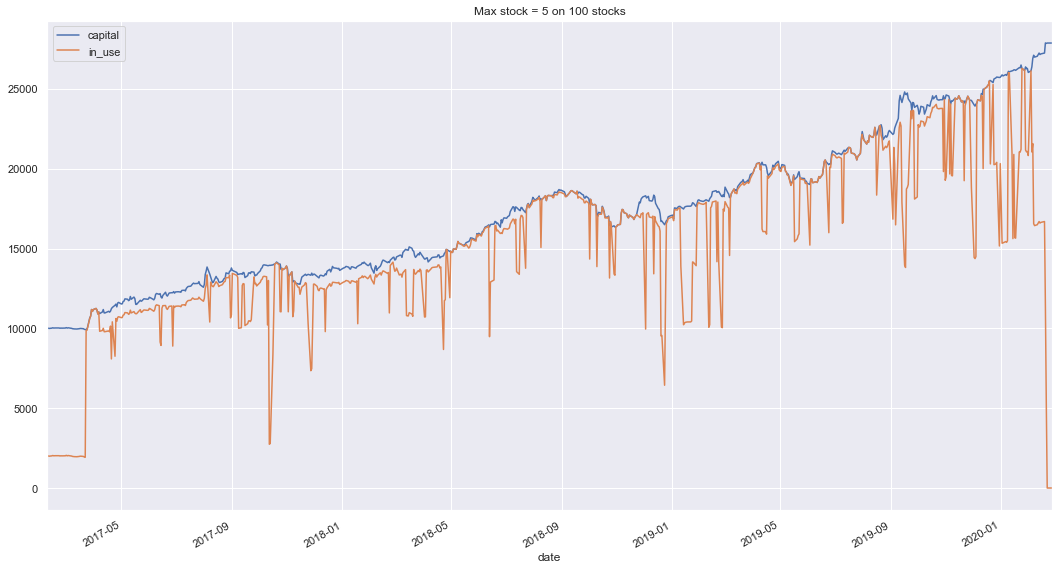

In [7]:
#myPnL_df, my_Capital_df = backtester()
myCapital_df = my_Capital_df
myCapital_df.index = myCapital_df.date
to_plot_cols = ['capital', 'in_use']
myCapital_df[to_plot_cols][first_buy_date:].plot(figsize=(18,10))
plt.title('Max stock = 5 on 100 stocks')
plt.show()

# Analysis of Results

The cells below perform a simple analysis. They look at the completed trades. For each trade it calculates the gain and gain percentage. With that it then displays the top ten losses and top ten gains. It ends with calculating the percentage of trades that resulted in a loss.

In [8]:
sell_df = myPnL_df[myPnL_df.action=='SELL'].copy()
sell_df['gain'] = (sell_df.close_amount - sell_df.orig_amount)
sell_df['gain_pct'] = round((sell_df.gain / sell_df.orig_amount)*100, 2)
sell_df['daily_comp_pct'] = (((1 + sell_df.gain_pct/100) ** (1/ sell_df.days_in_trade)) - 1)*100
sell_df

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
0,2017-03-24,NKSH,SELL,1984.745763,1931.134172,55.845407,31.986,-53.611591,-2.701182,2,0,-53.611591,-2.70,-1.359238
0,2017-03-24,TOWN,SELL,1984.745763,2003.895618,68.392342,26.118,19.149856,0.964852,2,0,19.149856,0.96,0.478853
0,2017-03-27,DLX,SELL,1984.745763,1976.096983,29.823377,59.895,-8.947013,-0.450721,3,0,-8.648779,-0.44,-0.146882
0,2017-03-28,GRIF,SELL,1984.745763,2028.241540,66.916580,26.694,2.007497,0.099075,4,0,43.495777,2.19,0.543060
0,2017-03-29,VZ,SELL,1976.565817,1954.710218,45.532500,39.069,-6.829875,-0.348189,4,0,-21.855600,-1.11,-0.278663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2020-02-04,DRI,SELL,5241.879026,5336.077697,46.175819,102.168,29.552524,0.556909,12,0,94.198672,1.80,0.148777
0,2020-02-06,TOWN,SELL,5232.251984,5217.168015,188.549621,24.975,-64.106871,-1.213852,13,0,-15.083970,-0.29,-0.022338
0,2020-02-19,WSTG,SELL,5206.032443,5987.451401,342.727613,13.671,630.618808,11.772233,12,0,781.418958,15.01,1.172225
0,2020-02-20,REGN,SELL,5280.502173,6104.204232,15.293391,310.752,-25.539964,-0.416656,19,0,823.702059,15.60,0.765896


In [9]:
sell_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 0 to 0
Data columns (total 14 columns):
date              286 non-null datetime64[ns]
ticker            286 non-null object
action            286 non-null object
orig_amount       286 non-null float64
close_amount      286 non-null float64
no_shares         286 non-null float64
stop_loss         286 non-null float64
daily_gain        286 non-null float64
daily_pct         286 non-null float64
days_in_trade     286 non-null int64
invested          286 non-null int64
gain              286 non-null float64
gain_pct          286 non-null float64
daily_comp_pct    286 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 33.5+ KB


In [10]:
sell_df.describe()

,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
count,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.0,286.000000,286.000000,286.000000
mean,3380.000377,3442.489005,224.013315,45.610640,-7.128144,-0.263187,13.202797,0.0,62.488628,1.937098,0.045447
std,883.377234,934.183976,535.970282,49.488621,101.577156,3.056682,19.785538,0.0,279.340911,8.587050,1.055211
min,1860.381375,1856.351669,6.028291,0.477000,-656.449028,-23.214794,1.000000,0.0,-623.565380,-21.150000,-10.792377
25%,2702.344110,2723.259604,46.517688,13.943250,-36.723911,-1.141153,2.000000,0.0,-31.868960,-1.137500,-0.193671
50%,3298.372382,3294.785867,111.650609,28.021500,0.000000,0.000000,5.000000,0.0,21.129769,0.610000,0.104754
75%,3925.202157,4011.953271,207.416872,59.544000,29.800833,0.941288,15.000000,0.0,130.661577,3.900000,0.418185
max,5280.502173,6104.204232,6376.456423,345.123000,630.618808,14.594310,172.000000,0.0,2157.419002,68.120000,4.836099


In [11]:
sell_df.sort_values(by='gain_pct', ascending=True)[0:10]

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
0,2017-11-07,TRIP,SELL,2753.707138,2171.269519,80.447185,30.80700,-656.449028,-23.214794,4,0,-582.437618,-21.15,-5.767563
0,2017-11-02,OPCH,SELL,2635.236608,2097.209134,274.503813,8.64000,-538.027474,-20.416667,2,0,-538.027474,-20.42,-10.792377
0,2017-09-15,TGA,SELL,2694.936272,2306.982154,2279.401397,1.06407,-366.527745,-13.709609,14,0,-387.954118,-14.40,-1.104462
0,2019-12-02,OPCH,SELL,4711.382869,4087.817489,346.425211,12.24000,-221.712135,-5.144695,9,0,-623.565380,-13.24,-1.565664
0,2018-10-02,SYX,SELL,3525.994904,3105.056282,126.788742,25.02900,-91.287894,-2.856010,17,0,-420.938622,-11.94,-0.745161
0,2018-12-24,IQV,SELL,3276.509659,2887.984248,27.322462,107.92800,-68.852605,-2.328590,41,0,-388.525412,-11.86,-0.307438
0,2018-07-23,AGRX,SELL,3379.521904,2984.181606,6376.456423,0.47700,-108.399759,-3.505155,14,0,-395.340298,-11.70,-0.884848
0,2019-06-03,PSDO,SELL,4075.276845,3606.982378,278.746706,13.15800,-66.899209,-1.820941,38,0,-468.294466,-11.49,-0.320681
0,2018-12-20,CVI,SELL,3146.345310,2789.332948,92.730484,30.53700,-112.203885,-3.867050,19,0,-357.012362,-11.35,-0.632068
0,2017-10-25,MBI,SELL,2794.825943,2479.859823,398.691290,6.30900,-171.437255,-6.466165,7,0,-314.966119,-11.27,-1.693667


In [12]:
sell_df.sort_values(by='gain_pct', ascending=False)[0:10]

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested,gain,gain_pct,daily_comp_pct
0,2017-04-07,SYX,SELL,1976.565817,3322.978968,391.399172,4.545,31.311934,0.951249,11,0,1346.413151,68.12,4.836099
0,2019-09-05,MEDP,SELL,3683.002268,5840.421270,70.596172,46.953,94.598870,1.646394,128,0,2157.419002,58.58,0.360875
0,2018-11-26,OPCH,SELL,3453.258677,4467.502484,301.858276,10.296,567.493559,14.551084,30,0,1014.243807,29.37,0.862049
0,2019-08-21,PRPL,SELL,4132.156193,5191.021217,645.649405,5.760,-64.564941,-1.228501,14,0,1058.865024,25.62,1.642568
0,2017-09-08,SYX,SELL,2556.838059,3201.275310,190.099484,12.105,-64.633825,-1.979045,36,0,644.437251,25.20,0.626237
0,2018-03-05,PANW,SELL,2775.706285,3423.719275,18.992174,131.535,66.472610,1.979974,48,0,648.012990,23.35,0.438156
0,2018-08-10,IQV,SELL,3307.826594,3975.232535,32.812485,90.729,-18.046867,-0.451931,34,0,667.405941,20.18,0.542112
0,2019-12-24,SYX,SELL,4598.207995,5461.295223,211.023772,19.611,25.322853,0.465839,29,0,863.087228,18.77,0.594931
0,2018-05-21,VSH,SELL,2862.913871,3397.125992,165.390749,15.579,47.963317,1.432099,13,0,534.212120,18.66,1.324792
0,2019-09-27,SPPI,SELL,4461.030734,5248.968433,592.434360,6.777,-159.957277,-2.957284,17,0,787.937699,17.66,0.961231


In [13]:
sell_df[sell_df.gain_pct < 0].count()[0], sell_df[sell_df.gain_pct < 0].count()[0]/len(sell_df)

(102, 0.35664335664335667)

In [14]:
myPnL_df

,date,ticker,action,orig_amount,close_amount,no_shares,stop_loss,daily_gain,daily_pct,days_in_trade,invested
0,2017-02-08,ORIT,BUY,2000.000000,2000.000000,141.242938,12.744,0.000000,0.000000,0,0
0,2017-02-08,ORIT,CLOSE,2000.000000,2000.000000,141.242938,12.744,0.000000,0.000000,1,0
0,2017-02-09,ORIT,CLOSE,2000.000000,2007.062147,141.242938,12.744,7.062147,0.353107,2,0
0,2017-02-10,ORIT,CLOSE,2000.000000,1994.350282,141.242938,12.744,-12.711864,-0.633357,3,0
0,2017-02-13,ORIT,CLOSE,2000.000000,2012.711864,141.242938,12.744,18.361582,0.920680,4,0
...,...,...,...,...,...,...,...,...,...,...,...
0,2020-02-19,CPB,CLOSE,5189.791784,5208.318970,108.983448,42.858,-44.683214,-0.850622,28,0
0,2020-02-19,REGN,CLOSE,5280.502173,6129.744196,15.293391,310.752,48.327117,0.794669,18,0
0,2020-02-20,REGN,SELL,5280.502173,6104.204232,15.293391,310.752,-25.539964,-0.416656,19,0
0,2020-02-20,CPB,CLOSE,5189.791784,5202.869797,108.983448,42.858,-5.449172,-0.104624,29,0


In [15]:
sell_df.ticker.unique(), len(sell_df.ticker.unique())

(array(['NKSH', 'TOWN', 'DLX', 'GRIF', 'VZ', 'JVA', 'FEIM', 'SYX', 'ALXN',
        'MBI', 'AMWD', 'REGN', 'CRL', 'CVX', 'CVI', 'OPCH', 'BLDR', 'MDP',
        'SPPI', 'VSH', 'TGA', 'HWC', 'AMT', 'TRNS', 'VIVO', 'OTEX', 'BB',
        'DRI', 'PEBK', 'GWB', 'PGR', 'BXP', 'ORIT', 'DSGX', 'PCAR', 'BOCH',
        'TRIP', 'MRC', 'EXLS', 'USPH', 'SLG', 'PANW', 'ORC', 'FOR', 'IQV',
        'HLT', 'AGRX', 'BMCH', 'LIND', 'FCFS', 'IPG', 'PRPL', 'PSDO',
        'CPB', 'FHB', 'MEDP', 'JELD', 'WSTG'], dtype=object), 58)

In [16]:
sell_df[['ticker', 'gain']].groupby(by='ticker').sum().reset_index().sort_values(by='gain', ascending=False)[0:10]

,ticker,gain
48,SYX,3090.690202
32,MEDP,2157.419002
47,SPPI,1614.397574
6,BMCH,1236.539993
52,TRNS,1108.841746
37,ORIT,982.007073
45,REGN,890.583453
35,OPCH,801.522777
57,WSTG,781.418958
55,VSH,767.709011


In [17]:
sell_df[['ticker', 'gain']].groupby(by='ticker').sum().reset_index().sort_values(by='gain', ascending=True)[0:10]

,ticker,gain
0,AGRX,-585.331026
51,TRIP,-492.487246
44,PSDO,-468.294466
17,FCFS,-434.099881
49,TGA,-409.478837
31,MDP,-266.776574
4,BB,-204.375534
54,VIVO,-151.017282
24,HWC,-133.394001
28,JVA,-77.329279


In [18]:
sell_df[['ticker', 'gain']].groupby(by='ticker').mean().reset_index().sort_values(by='gain', ascending=False)[0:10]

,ticker,gain
32,MEDP,2157.419002
57,WSTG,781.418958
27,JELD,389.281729
48,SYX,343.410022
45,REGN,296.861151
29,LIND,238.617113
43,PRPL,213.262568
6,BMCH,206.089999
47,SPPI,201.799697
36,ORC,179.829692


In [19]:
sell_df[['ticker', 'gain']].groupby(by='ticker').mean().reset_index().sort_values(by='gain', ascending=True)[0:10]

,ticker,gain
44,PSDO,-468.294466
0,AGRX,-292.665513
17,FCFS,-217.049941
4,BB,-102.187767
49,TGA,-81.895767
51,TRIP,-44.771568
31,MDP,-38.110939
54,VIVO,-37.754321
24,HWC,-26.678800
28,JVA,-19.332320


In [20]:
myCapital_df.tail()

,date,capital,in_use,free
date,,,,
2020-02-20,2020-02-20,27847.8,5202.87,22644.9
2020-02-21,2020-02-21,27871.7,0,27871.7
2020-02-24,2020-02-24,27871.7,0,27871.7
2020-02-25,2020-02-25,27871.7,0,27871.7
2020-02-26,2020-02-26,27871.7,0,27871.7


In [21]:
len(possible_trades_df)

913

# Save The DataFrames

In [22]:
possible_trades_df.to_csv(f'{DATAPATH}possible_trades_0100.csv', index=False)
myCapital_df.to_csv(f'{DATAPATH}capital_0100.csv', index=False)
myPnL_df.to_csv(f'{DATAPATH}PnL_0100.csv', index=False)

In [23]:
!ls ../data

F13_Renaissance_tech.csv capital_0500.csv         possible_trades_1000.csv
F13_Renaissance_tech.txt capital_1000.csv         possible_trades_1500.csv
PnL_0100.csv             capital_1500.csv         possible_trades_2000.csv
PnL_0500.csv             capital_2000.csv         stocks.csv
PnL_1000.csv             exclude.csv              stocks_100.csv
PnL_1500.csv             optimal_params.csv       stocks_1000.csv
PnL_2000.csv             possible_trades_0100.csv stocks_2000.csv
capital_0100.csv         possible_trades_0500.csv stocks_500.csv


In [24]:
cols = ['ticker', 'trading_days', 'gain_pct', 'daily_return']
mean_df = possible_trades_df[cols].groupby('ticker').agg(['mean']).reset_index()
mean_df.columns=['ticker', 'trading_days', 'gain_pct', 'daily_return']
mean_df

,ticker,trading_days,gain_pct,daily_return
0,AA,15.578947,-0.379474,-0.102632
1,ADRO,68.000000,-29.645000,0.060000
2,AGRX,57.500000,32.070000,0.200000
3,ALXN,79.000000,1.706000,0.042000
4,AMT,37.666667,5.395833,0.185000
...,...,...,...,...
79,USPH,25.363636,3.235455,0.259091
80,VIVO,29.125000,0.688750,0.048750
81,VSH,21.062500,4.331875,-0.195000
82,VZ,15.411765,3.554706,0.157059
